In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading and Exploration
data = pd.read_csv("/content/drive/MyDrive/Data_set/ML project/online_shoppers_intention.csv")

print("Data Info:")
data.info()

print("\nData Description:")
print(data.describe())

print("\nMissing Values:")
print(data.isnull().sum())

print("\nTarget Distribution:")
print(data['Revenue'].value_counts())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType

Data preprocessing

In [ ]:
X = data.drop("Revenue", axis=1)
y = data['Revenue'].astype(int)

categorical_features = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend','SpecialDay']
numeric_features =  ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

# Create New Features
X["total_duration"] = X[numeric_features[:6]].sum(axis=1)
X["avg_duration_admin"] = X['Administrative_Duration'] / (X["Administrative"]+1)
X["avg_duration_info"] = X['Informational_Duration'] / (X["Informational"]+1)
X["avg_duration_product"] = X['ProductRelated_Duration'] / (X["ProductRelated"]+1)

numeric_features.extend(["total_duration", "avg_duration_admin", "avg_duration_info", "avg_duration_product"])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# 3. Model Building
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_model.fit(X_train, y_train)

# 4. Prediction and Evaluation
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:36:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.8913219789132197

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      3127
           1       0.69      0.54      0.61       572

    accuracy                           0.89      3699
   macro avg       0.80      0.75      0.77      3699
weighted avg       0.88      0.89      0.89      3699


Confusion Matrix:
 [[2986  141]
 [ 261  311]]


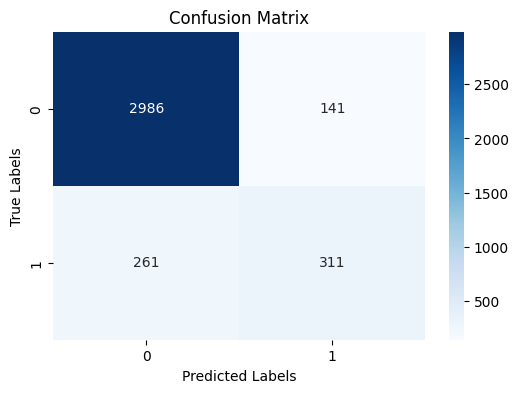

In [ ]:
# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))


print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

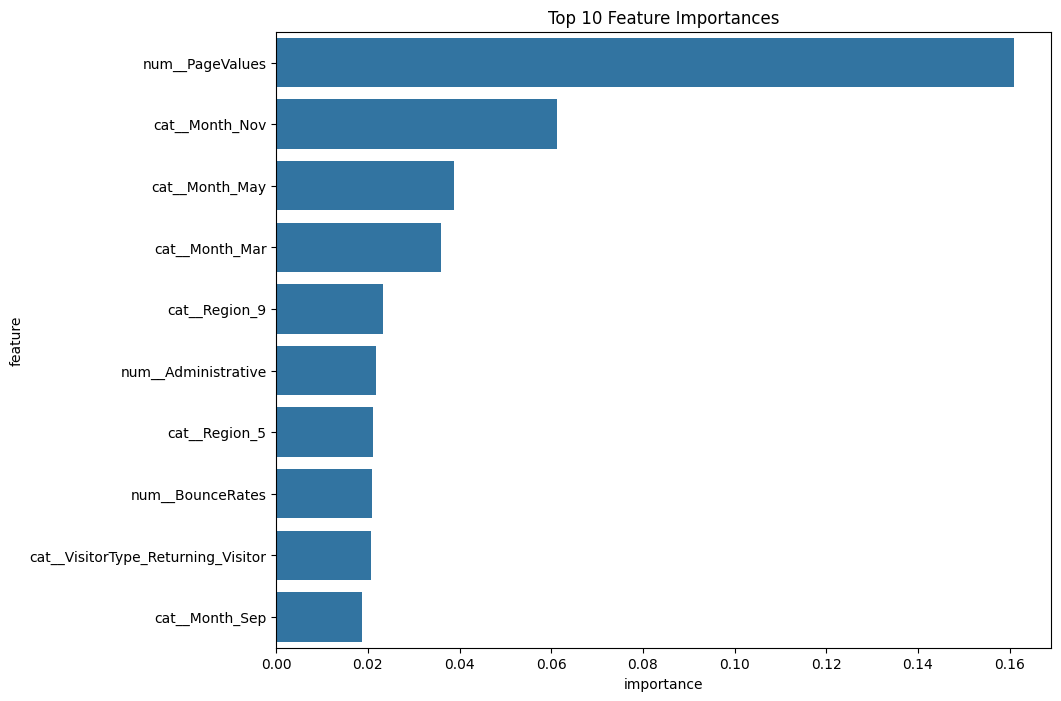

In [ ]:
# 5. (Optional) Feature Importance
feature_names = preprocessor.get_feature_names_out()
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance':importances})
feature_importance_df = feature_importance_df.sort_values('importance',ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()